<a href="https://colab.research.google.com/github/dnmuturi/SIT742/blob/main/SIT742Task2code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**END TERM ASSIGNMENT**

 **GROUP C30 Members**

1. David Muturi - S225177509
2. Nhlanhla Matukane - S225177376
3. Vincent Nwobi -

### **Part 1**

**Answer 1.1**

In [137]:
#install the spark library
!pip install pyspark

In [138]:
#load necessary libraries
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
import pandas as pd
from pyspark.sql.functions import col, from_unixtime, to_date, when, lit, trim, count, date_format,avg

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns


In [139]:
# Mount Google Drive
drive.mount('/content/drive')
# Define the path to the CSV file
csv_path = '/content/drive/My Drive/SIT742/review.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
# Create a SparkSession
spark = SparkSession.builder.appName("ReadCSVCorrectly").getOrCreate()
# Read the CSV file into a PySpark DataFrame with options to improve parsing
try:
    df_review= spark.read.csv(
        csv_path,
        header=True,
        inferSchema=True,
        sep=',',  # Assuming comma is the delimiter
        quote='"', # Assuming double quotes are used for quoting fields
        escape='"', # Assuming double quotes are escaped by double quotes
        multiLine=True # Set to true if text column contains newline characters
    )
    print("CSV file loaded successfully!")
    df_review.show(5, truncate=False) # Display the first five rows without truncating
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully!
+---------------------+-----------------+-------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----+-------------------------------------+
|user_id              |name             |time         |rating|text                                                

In [141]:
# show data tpes
df_review.printSchema()

root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



In [142]:
#show summary statistics
df_review.describe().show()

+-------+--------------------+------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|summary|             user_id|        name|                time|            rating|                text|                pics|                resp|             gmap_id|
+-------+--------------------+------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              521515|      521515|              521515|            521515|              298257|               20851|               44232|              521515|
|   mean|1.091263946357014...|1.59456176E8|1.550301924036441E12| 4.283750227701984|                NULL|                NULL|                NULL|                NULL|
| stddev|5.306023249666912...|         0.0|  3.8404430568757E10|1.0356221247508024|                NULL|                NULL|                NULL|              

**Answer 1.1.1**

In [143]:
#function to count rows that are none or null
def show_empty_rows(df):
  # Filter rows where 'text' column is null or an empty string
  null_or_empty_text_count = df.filter(
    col("text").isNull() | (trim(col("text")) == "")
  ).count()
  return null_or_empty_text_count

In [144]:
#show count of empty rows in text field before filling in with no review
print(f"The number of empty rows in the text column before replacing with 'no review' is: {show_empty_rows(df_review)}")

The number of empty rows in the text column before replacing with 'no review' is: 223258


In [145]:
# Replace null values with "No review"
df_review = df_review.fillna({'text': 'no review'})

# Replace empty strings (after trimming whitespace) with "No review"
df_review = df_review.withColumn("text",
    when(trim(col("text")) == "", lit("no review")).otherwise(col("text"))
)

# Show the count of text column with  to verify the changes
print(f"The number of empty rows in the text column after replacing with no review is: {show_empty_rows(df_review)}")

# Count rows where the 'text' column is 'no review'
no_review_count = df_review.filter(col("text") == "no review").count()

print(f"The number of reviews with 'no review' in the text column is: {no_review_count}")


The number of empty rows in the text column after replacing with no review is: 0
The number of reviews with 'no review' in the text column is: 223258


**Answer 1.1.2**

In [146]:
# Set the time parser policy to legacy to handle potential parsing issues
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Convert 'time' from epoch milliseconds to a timestamp, then to a date string
df_review = df_review.withColumn(
    "newtime",
    to_date(from_unixtime(col("time") / 1000), "yyyy-MM-dd")
)

# Display the first few rows with the new column
df_review.select("user_id","name","rating","time", "newtime","text","gmap_id").show(5)

+--------------------+-----------------+------+-------------+----------+--------------------+--------------------+
|             user_id|             name|rating|         time|   newtime|                text|             gmap_id|
+--------------------+-----------------+------+-------------+----------+--------------------+--------------------+
|1.091298048426862E20|       Nicki Gore|     5|1566331951619|2019-08-20|We always stay he...|0x56b646ed2220b77...|
|1.132409264057589...|    Allen Ratliff|     5|1504917982385|2017-09-09|Great campground ...|0x56b646ed2220b77...|
|1.130448378911412...|Jonathan Tringali|     4|1474765901185|2016-09-25|We tent camped he...|0x56b646ed2220b77...|
|1.103291551475920...|           S Blad|     4|1472858535682|2016-09-02|This place is jus...|0x56b646ed2220b77...|
| 1.08989634908602E20|   Daniel Formoso|     5|1529649811341|2018-06-22|Probably the nice...|0x56b646ed2220b77...|
+--------------------+-----------------+------+-------------+----------+--------

**Answer 1.2**

**Answer 1.2.1**

In [147]:
# Calculate the number of reviews per unique gmap_id
reviews_per_gmap = df_review.groupBy("gmap_id").agg(count("*").alias("review_count"))

# Cast the review_count to float type
reviews_per_gmap = reviews_per_gmap.withColumn("review_count", col("review_count").cast(DoubleType()))

# Show the top 5 results
print("Number of reviews per unique gmap_id (Top 5):")
reviews_per_gmap.orderBy(col("review_count").desc()).show(5)

Number of reviews per unique gmap_id (Top 5):
+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c897b9ce6000d...|      2833.0|
|0x56c899d05892048...|      2594.0|
|0x56c897c63697ee3...|      2258.0|
|0x56c8965ee2fb87a...|      2237.0|
|0x56c89629bde7481...|      2219.0|
+--------------------+------------+
only showing top 5 rows



**Answer 1.2.2**

In [148]:
# Convert PySpark DataFrame to pandas DataFrame
df = df_review.toPandas()

# Create 'review_time' column at the hour level
df['review_time'] = pd.to_datetime(df['time'], unit='ms').dt.hour

# Display the first 5 rows of the pandas DataFrame
print("Pandas DataFrame with 'review_time' column (Top 5):")
display(df.head())

Pandas DataFrame with 'review_time' column (Top 5):


,user_id,name,time,rating,text,pics,resp,gmap_id,newtime,review_time
0,1.091298e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2019-08-20,20
1,1.132409e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2017-09-09,0
2,1.130448e+20,Jonathan Tringali,1474765901185,4,We tent camped here for 2 nights while explori...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-25,1
3,1.103292e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,2016-09-02,23
4,1.089896e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,2018-06-22,6


**Answer 1.2.3**

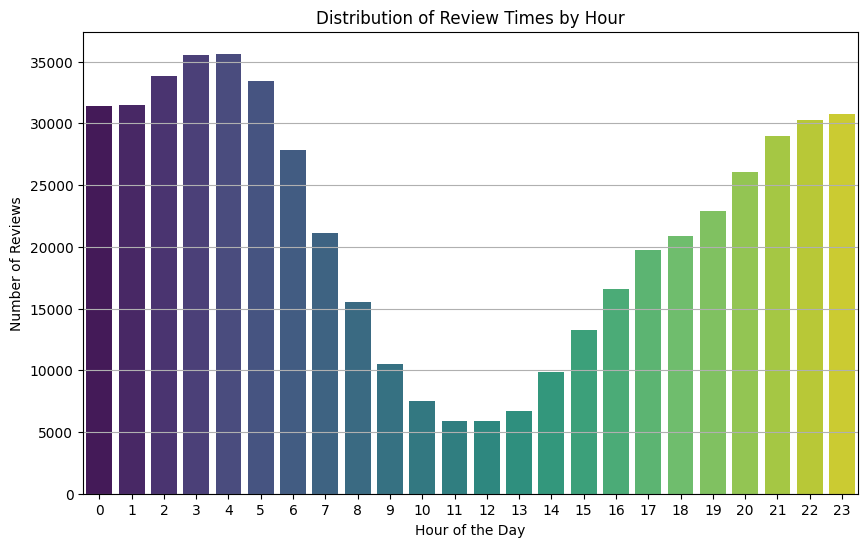

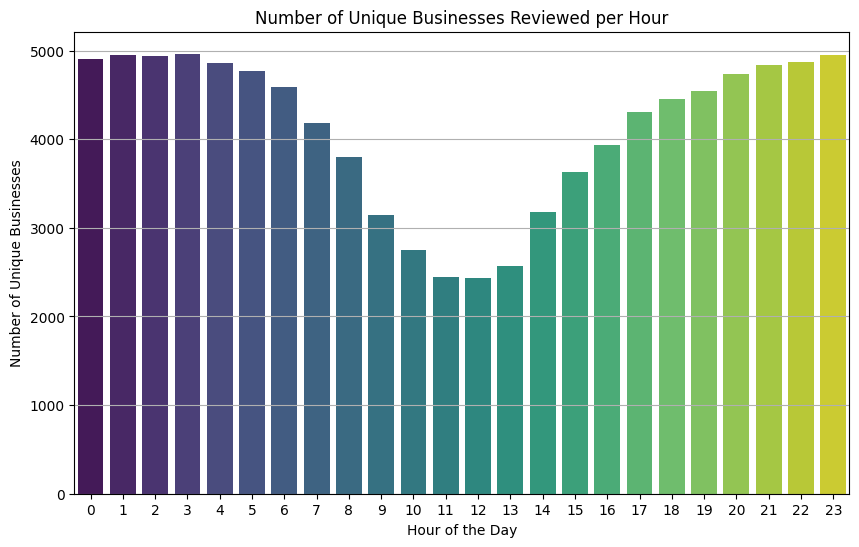

In [149]:
# Analyze the distribution of reviews by hour
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='review_time', palette='viridis')
plt.title('Distribution of Review Times by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

# Analyze the number of businesses reviewed at different times
# For simplicity, let's consider the number of unique gmap_ids that have reviews at each hour.
unique_gmap_ids_per_hour = df.groupby('review_time')['gmap_id'].nunique().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=unique_gmap_ids_per_hour, x='review_time', y='gmap_id', palette='viridis')
plt.title('Number of Unique Businesses Reviewed per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Unique Businesses')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

### Insights from Visualizations

The visualizations above provide insights into the review patterns based on the time of day:

**Distribution of Review Times by Hour:**
- The first plot shows the total number of reviews submitted at each hour of the day.
- We can observe that there is a peak in reviews during certain hours, indicating when users are most active in leaving feedback. This could be related to business operating hours, user routines, or other factors.

**Number of Unique Businesses Reviewed per Hour:**
- The second plot shows the number of distinct businesses (identified by `gmap_id`) that received at least one review during each hour.
- This helps understand if reviews are spread across many businesses throughout the day or concentrated on a few during specific times.

Further analysis could involve looking at the average rating per hour, the types of businesses reviewed at different times, or correlating review times with other factors in the dataset.

**Answer 1.3**

**Answer 1.3.1**

In [150]:
# Define the path to the second CSV file
meta_csv_path = '/content/drive/My Drive/SIT742/meta-review-business.csv'

# Read the second CSV file into a PySpark DataFrame
try:
    df_meta = spark.read.csv(
        meta_csv_path,
        header=True,
        inferSchema=True,
        sep=',',  # Assuming comma is the delimiter
        quote='"', # Assuming double quotes are used for quoting fields
        escape='"', # Assuming double quotes are escaped by double quotes
        multiLine=True # Set to true if text column contains newline characters
    )
    print("Meta CSV file loaded successfully!")
    df_meta.show(5, truncate=False) # Display the first five rows without truncating
except Exception as e:
    print(f"An error occurred while loading meta CSV: {e}")

Meta CSV file loaded successfully!
+---------------------------+------------------------------------------------------------------+-------------------------------------+-----------+------------------+-------------------+------------------------------------------------+----------+--------------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------

**Answer 1.3.2**

In [151]:
# Join the two DataFrames on the 'gmap_id' column
joined_df = df_review.join(df_meta, on="gmap_id", how="inner")

# Show the schema and some rows of the joined DataFrame
print("Joined DataFrame Schema:")
joined_df.printSchema()

print("Joined DataFrame (Top 5):")
joined_df.show(5, truncate=False)

Joined DataFrame Schema:
root
 |-- gmap_id: string (nullable = true)
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = false)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- newtime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)

Joined DataFrame (Top 5):
+-------------------------------------+-------------

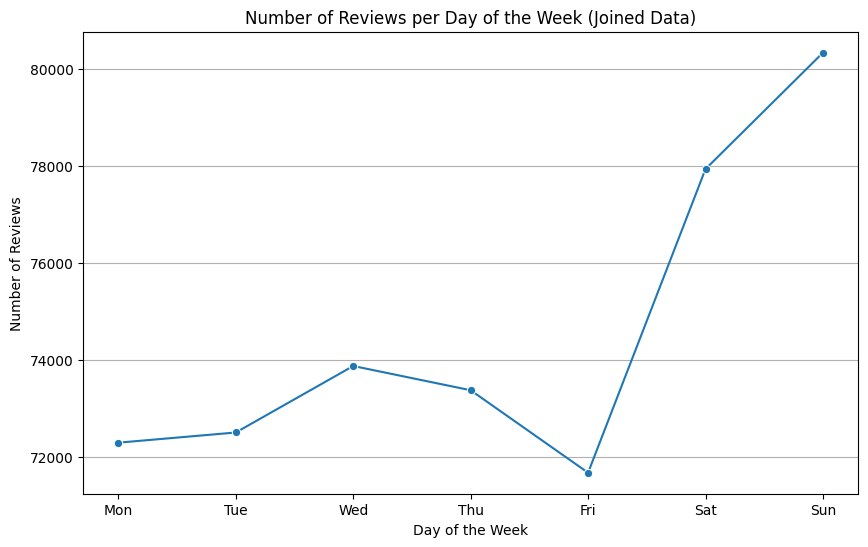

In [152]:
# Extract the day of the week from the 'newtime' column
joined_df_with_day = joined_df.withColumn("day_of_week", date_format(col("newtime"), "E"))

# Group by day of the week and count the reviews
reviews_by_day = joined_df_with_day.groupBy("day_of_week").count()

# Define the order of the days of the week for plotting
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Convert to pandas DataFrame for plotting
reviews_by_day_pd = reviews_by_day.toPandas()

# Sort the pandas DataFrame by the defined day order
reviews_by_day_pd['day_of_week'] = pd.Categorical(reviews_by_day_pd['day_of_week'], categories=day_order, ordered=True)
reviews_by_day_pd = reviews_by_day_pd.sort_values('day_of_week')


# Plot the results as a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=reviews_by_day_pd, x='day_of_week', y='count', marker='o')
plt.title('Number of Reviews per Day of the Week (Joined Data)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.show()

In [153]:
# Find the day with the maximum number of reviews
peak_day = reviews_by_day_pd.loc[reviews_by_day_pd['count'].idxmax()]['day_of_week']
print(f"The workday with the most reviews is: {peak_day}")

# Rename the 'name' column in df_meta to avoid ambiguity
df_meta_renamed = df_meta.withColumnRenamed("name", "business_name")

# Re-join the dataframes with the renamed column
# Ensure the 'newtime' column and 'day_of_week' are still available after re-joining

joined_df_renamed = df_review.join(df_meta_renamed, on="gmap_id", how="inner")
joined_df_with_day = joined_df_renamed.withColumn("day_of_week", date_format(col("newtime"), "E"))


# Filter the joined DataFrame for the peak day
peak_day_df = joined_df_with_day.filter(col("day_of_week") == peak_day)

# Group by business name and category and calculate the average rating
avg_rating_by_business = peak_day_df.groupBy("business_name", "category").agg(avg("rating").alias("average_rating"))

# Find the business(es) with the highest average rating on the peak day
highest_rated_businesses = avg_rating_by_business.orderBy(col("average_rating").desc()).limit(5)

print(f"\nBusinesses with the highest average rating on {peak_day} (Top 5):")
highest_rated_businesses.show(truncate=False)

The workday with the most reviews is: Sun

Businesses with the highest average rating on Sun (Top 5):
+--------------------------------------+-------------------------------------------+--------------+
|business_name                         |category                                   |average_rating|
+--------------------------------------+-------------------------------------------+--------------+
|Stony Hill Scenic Overlook            |['Vista point', 'Tourist attraction']      |5.0           |
|Novus Glass                           |['Auto glass shop', 'Glass repair service']|5.0           |
|Rugged Brews                          |['Coffee shop']                            |5.0           |
|Morgan's Landing State Recreation Area|['State park', 'Tourist attraction']       |5.0           |
|Ptarmigan Campground                  |['Campground']                             |5.0           |
+--------------------------------------+-------------------------------------------+--------------

**Answer 1.3.3**

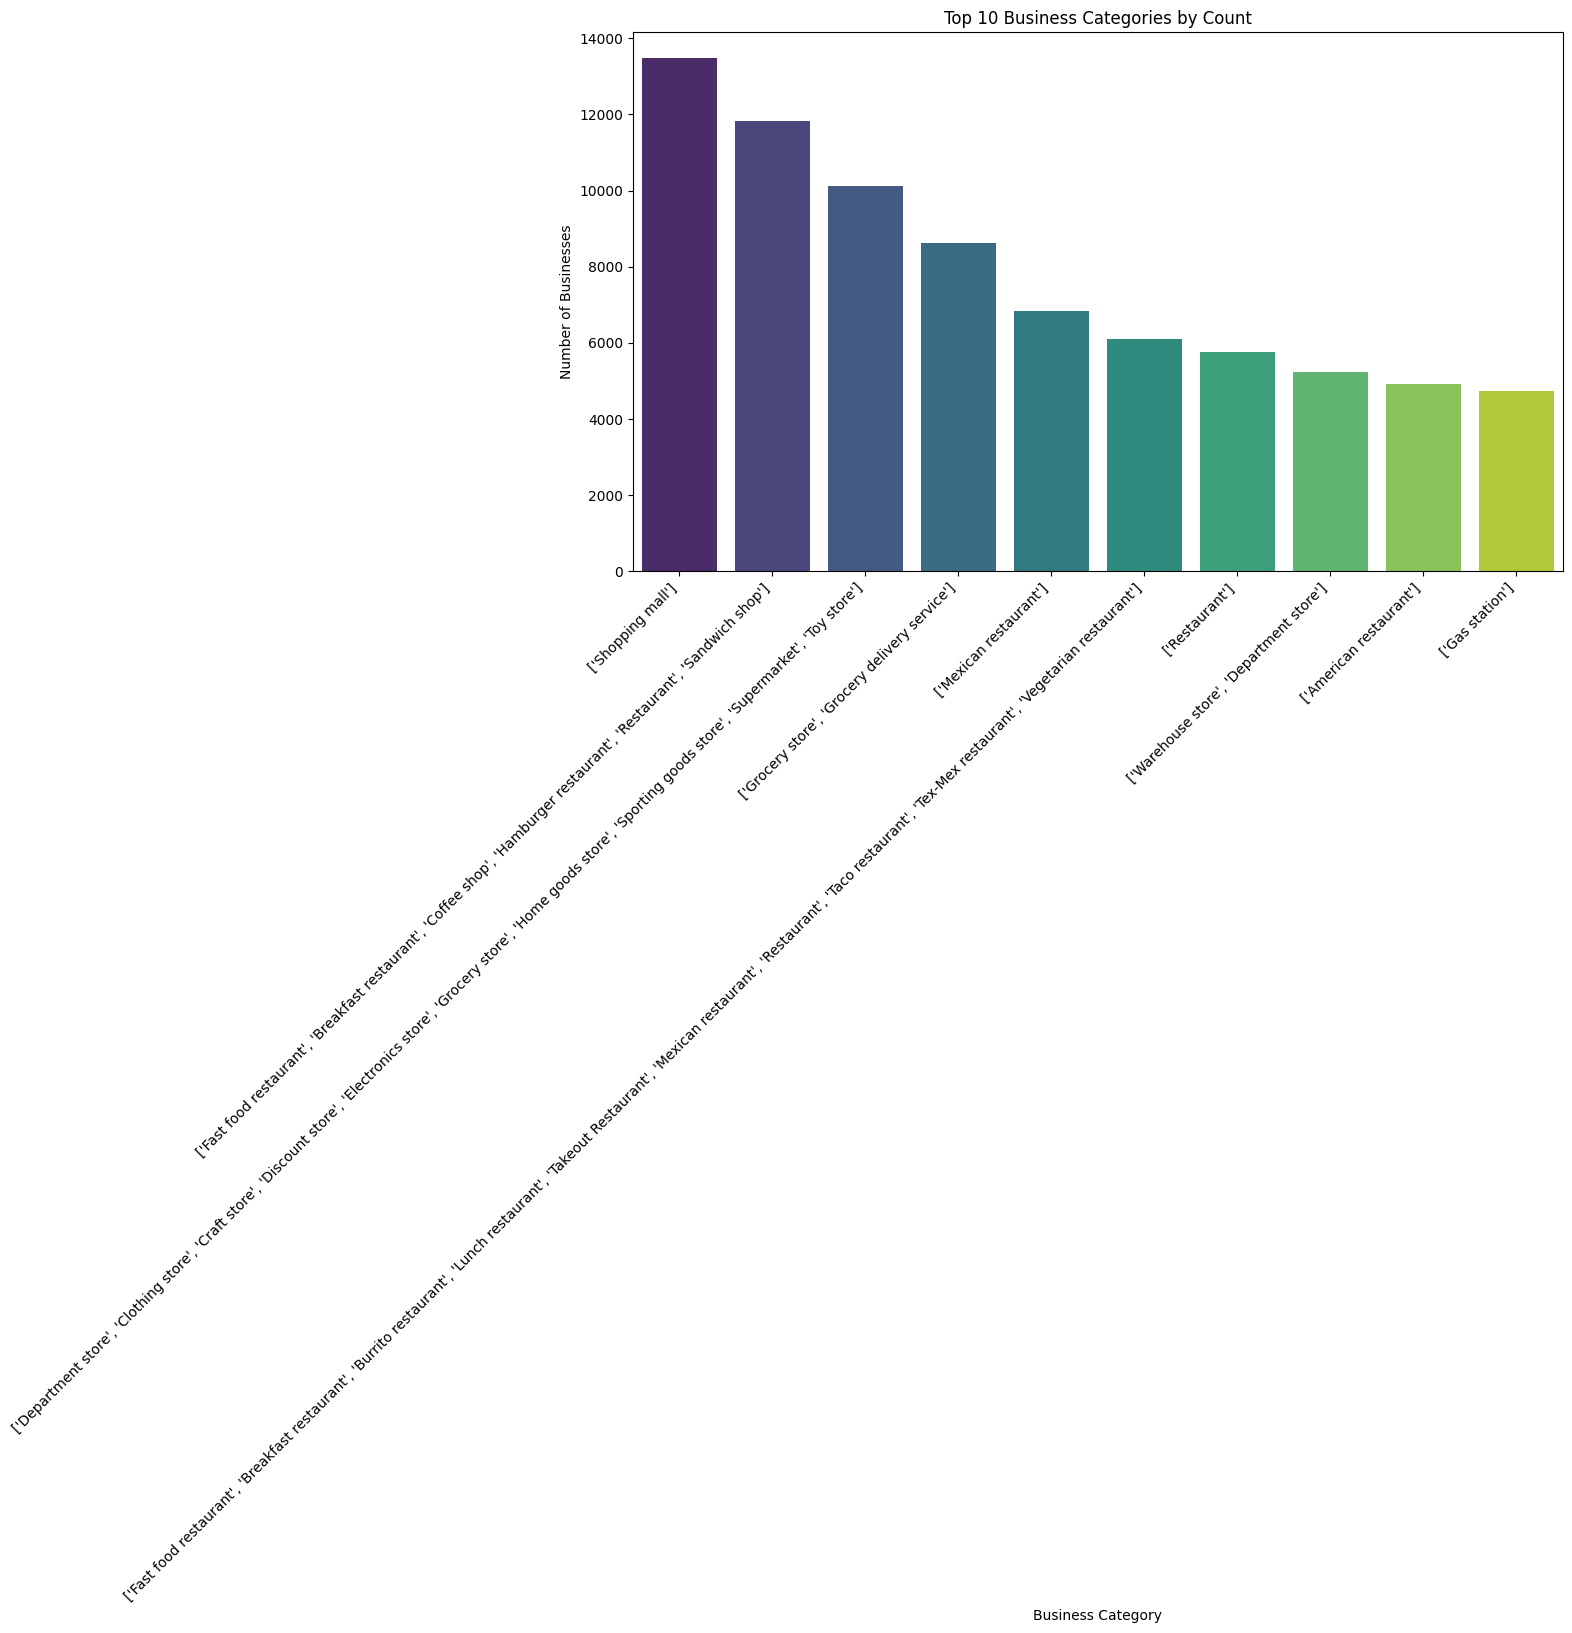

In [154]:
# Group by category and count the number of businesses
category_counts = joined_df_renamed.groupBy("category").count()

# Order by count in descending order
category_counts = category_counts.orderBy(col("count").desc())

# Convert to pandas DataFrame
category_counts_pd = category_counts.toPandas()

# Select the top 10 categories
top_10_categories = category_counts_pd.head(10)

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_categories, x='category', y='count', palette='viridis')
plt.title('Top 10 Business Categories by Count')
plt.xlabel('Business Category')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [155]:
# Get the list of top 10 categories
top_categories_list = top_10_categories['category'].tolist()

# Filter the joined DataFrame to include only the top 10 categories
filtered_df = joined_df_with_day.filter(col("category").isin(top_categories_list))

# Extract the hour of the day from the 'newtime' column
filtered_df = filtered_df.withColumn("review_hour", date_format(col("newtime"), "H"))

# Show the schema and some rows of the filtered DataFrame with the new column
print("Filtered DataFrame Schema:")
filtered_df.printSchema()

print("Filtered DataFrame (Top 5):")
filtered_df.show(5, truncate=False)

Filtered DataFrame Schema:
root
 |-- gmap_id: string (nullable = true)
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = false)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- newtime: date (nullable = true)
 |-- business_name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- description: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- category: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- num_of_reviews: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- hours: string (nullable = true)
 |-- MISC: string (nullable = true)
 |-- state: string (nullable = true)
 |-- relative_results: string (nullable = true)
 |-- url: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- review_hour: string 

In [156]:
# Group by category and review_hour and count the number of reviews
reviews_by_category_hour = filtered_df.groupBy("category", "review_hour").count()

# Find the peak review hour for each category
# This requires window functions to partition by category and order by count
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

window_spec = Window.partitionBy("category").orderBy(col("count").desc())

ranked_reviews = reviews_by_category_hour.withColumn("rank", rank().over(window_spec))

peak_hours_per_category = ranked_reviews.filter(col("rank") == 1)

# Display the peak review hour for each of the top 10 categories
print("Peak review hour for each of the top 10 categories:")
peak_hours_per_category.show(truncate=False)

Peak review hour for each of the top 10 categories:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----+----+
|category                                                                                                                                                                                                              |review_hour|count|rank|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----+----+
|['American restaurant']                                                                                                                                                                                               |0          |

## Analyze average ratings by category


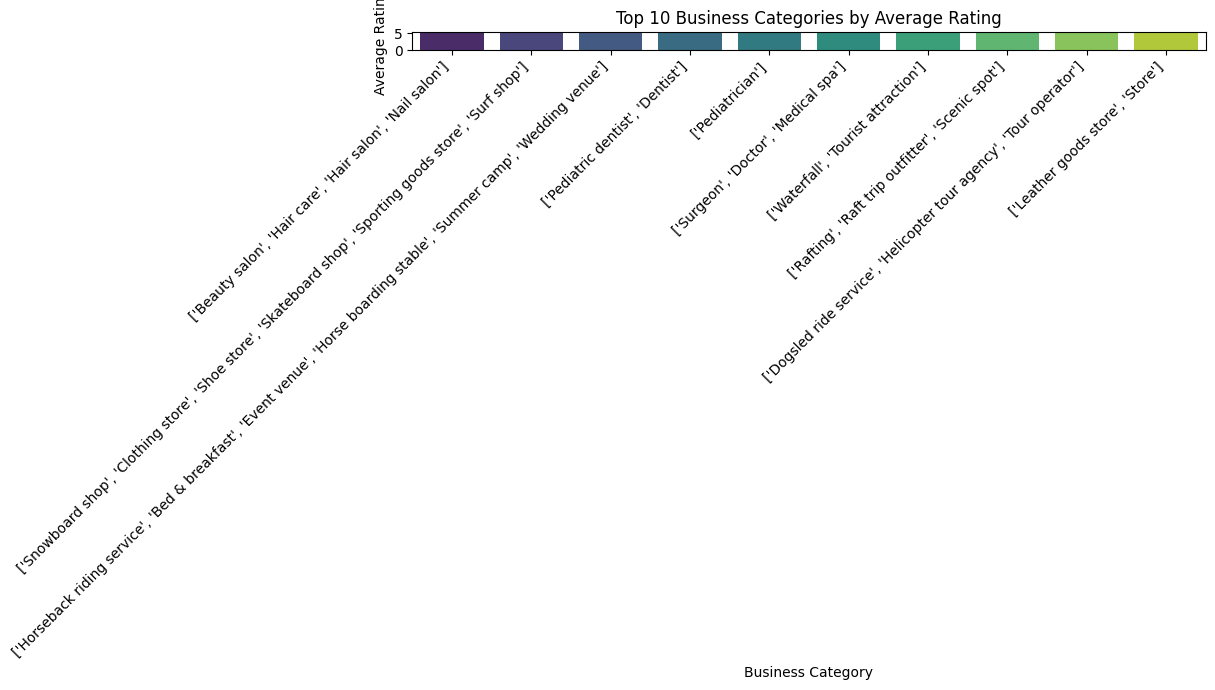

In [157]:
# Group by category and calculate the average rating
avg_rating_by_category = joined_df_renamed.groupBy("category").agg(avg("rating").alias("average_rating"))

# Order by average_rating in descending order
avg_rating_by_category = avg_rating_by_category.orderBy(col("average_rating").desc())

# Convert to pandas DataFrame
avg_rating_by_category_pd = avg_rating_by_category.toPandas()

# Select the top 10 categories by average rating
top_10_avg_rating_categories = avg_rating_by_category_pd.head(10)

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=top_10_avg_rating_categories, x='category', y='average_rating', palette='viridis')
plt.title('Top 10 Business Categories by Average Rating')
plt.xlabel('Business Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis Summary:**

Business Categories, Peak Hours, and Average Ratings
This analysis explored review patterns based on business categories, focusing on the distribution of businesses, peak review hours for top categories, and average ratings across categories.

Distribution of Businesses Across Categories:

Based on the analysis of business categories, the most frequent categories in the dataset are:

['Shopping mall']
['Fast food restaurant', 'Breakfast restaurant', 'Hamburger restaurant', 'Restaurant', 'Sandwich shop']
['Department store', 'Clothing store', 'Craft store', 'Shoe store', 'Sporting goods store']
['Grocery store', 'Grocery delivery service']
['Mexican restaurant']
['Fast food restaurant', 'Breakfast restaurant', 'Burger joint', 'Restaurant', 'Sandwich shop']
['Restaurant']
['Warehouse store', 'Department store']
['American restaurant']
['Gas station']
The bar plot titled "Top 10 Business Categories by Count" visually represents this distribution, clearly showing the categories with the highest number of associated businesses.

Peak Review Hours for Top Categories:

The analysis of peak review hours for the top 10 business categories revealed that for all of these categories, the hour with the highest number of reviews is '0' (which likely corresponds to midnight or the beginning of the day, depending on the exact time data representation).

Average Ratings by Category:

The calculation of average ratings by category identified the categories with the highest average ratings. The top 10 categories by average rating are:

['Beauty salon', 'Hair care', 'Hair salon', 'Nail salon']
['Snowboard shop', 'Clothing store', 'Shoe store', 'Ski shop', 'Sporting goods store', 'Store']
['Horseback riding service', 'Bed & breakfast', 'Cabin rental agency', 'Cottage', 'Guest house']
['Pediatric dentist', 'Dentist']
['Pediatrician']
['Surgeon', 'Doctor', 'Medical spa']
['Waterfall', 'Tourist attraction']
['Rafting', 'Raft trip outfitter', 'Scenic spot']
['Dogsled ride service', 'Helicopter tour agency', 'Tour operator']
['Leather goods store', 'Store']
The bar plot titled "Top 10 Business Categories by Average Rating" illustrates these top-rated categories and their corresponding average ratings.

Visualizations Summary:

Distribution of Review Times by Hour: A bar plot showing the total number of reviews submitted at each hour of the day, highlighting peak review hours across all businesses.
Number of Unique Businesses Reviewed per Hour: A bar plot illustrating the number of distinct businesses that received reviews during each hour, indicating the spread of review activity throughout the day.
Number of Reviews per Day of the Week (Joined Data): A line plot showing the trend of review counts across the days of the week, revealing which days have the highest review activity.
Top 10 Business Categories by Count: A bar plot displaying the frequency of the most common business categories in the dataset.
Top 10 Business Categories by Average Rating: A bar plot showcasing the average ratings for the categories with the highest overall sentiment.
These visualizations collectively provide a comprehensive overview of review patterns in the dataset, highlighting popular business categories, peak review times, and categories with the most favorable ratings.